In [1]:
import gen as g
from tqdm import tqdm

In [2]:
def generate():
    dead_farmers = 0
    
    
    
    recommended_species = None
    
    chosen_class = None
    
    background = None

    while not (recommended_species and chosen_class and background):
        
        stats, attempts = g.roll_stats()
        
        dead_farmers += attempts

        recommended_species = g.recommend_species(stats)
        
        
        updated_stats = g.apply_species_bonus(stats, recommended_species)

        optimal_stats = g.sort_stats(updated_stats)
    
        chosen_class = g.select_class(optimal_stats)
    
        background = g.pick_background(optimal_stats)
    
    return recommended_species, chosen_class, background
    

In [3]:
def track_species_selection(num_iterations):
    species_count = {}
    classes_count = {}
    background_count = {}
    for _ in tqdm(range(num_iterations)):
        species, chosen_class, chosen_background = generate()
        if species in species_count:
            species_count[species] += 1
        else:
            species_count[species] = 1
            
        if chosen_class in classes_count:
            classes_count[chosen_class] += 1
        else:
            classes_count[chosen_class] = 1
            
        if chosen_background in background_count:
            background_count[chosen_background] += 1
        else:
            background_count[chosen_background] = 1

    return species_count, classes_count, background_count

species_results, class_results, background_results = track_species_selection(10000)

for species, count in species_results.items():
    print(f"{species}: {count}")
    
for chosen_class, count in class_results.items():
    print(f"{chosen_class}: {count}")
    
for chosen_background, count in background_results.items():
    print(f"{chosen_background}: {count}")

100%|███████████████████████████████████████| 10000/10000 [00:53<00:00, 185.59it/s]

Elf (Wood): 654
Dwarf (Mountain): 321
Halfling (Lightfoot): 510
Elf (High): 1131
Gnome (Forest): 217
Half-Elf: 2547
Half-Orc: 273
Halfling (Stout): 565
Gnome (Rock): 166
Human: 1973
Tiefling: 317
Dragonborn: 265
Dwarf (Hill): 463
Elf (Drow): 598
Ranger: 796
Fighter: 1704
Artificer: 1109
Warlock: 419
Wizard: 1114
Cleric: 1211
Paladin: 525
Druid: 325
Rogue: 1128
Sorcerer: 431
Monk: 348
Bard: 809
Barbarian: 81
Sailor: 563
Sage: 1143
Knight: 389
Criminal/Spy: 849
Charlatan: 907
Folk Hero: 589
Urchin: 873
Soldier: 430
Pirate: 568
Acolyte: 1186
Noble: 392
Hermit: 372
Outlander: 566
Entertainer: 421
Guild Artisan: 368
Gladiator: 384


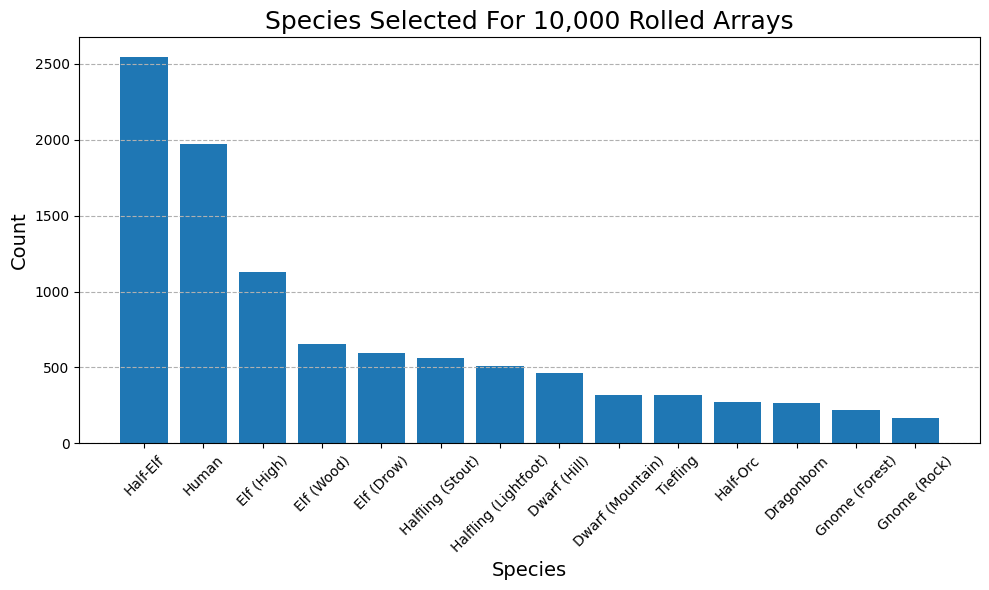

In [4]:
import matplotlib.pyplot as plt
sorted_species = sorted(species_results.items(), key=lambda item: item[1], reverse=True)
    
species, counts = zip(*sorted_species)

plt.figure(figsize=(10, 6))
plt.bar(species, counts)
plt.title('Species Selected For 10,000 Rolled Arrays', fontsize = 18)
plt.xlabel('Species', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('results.png')

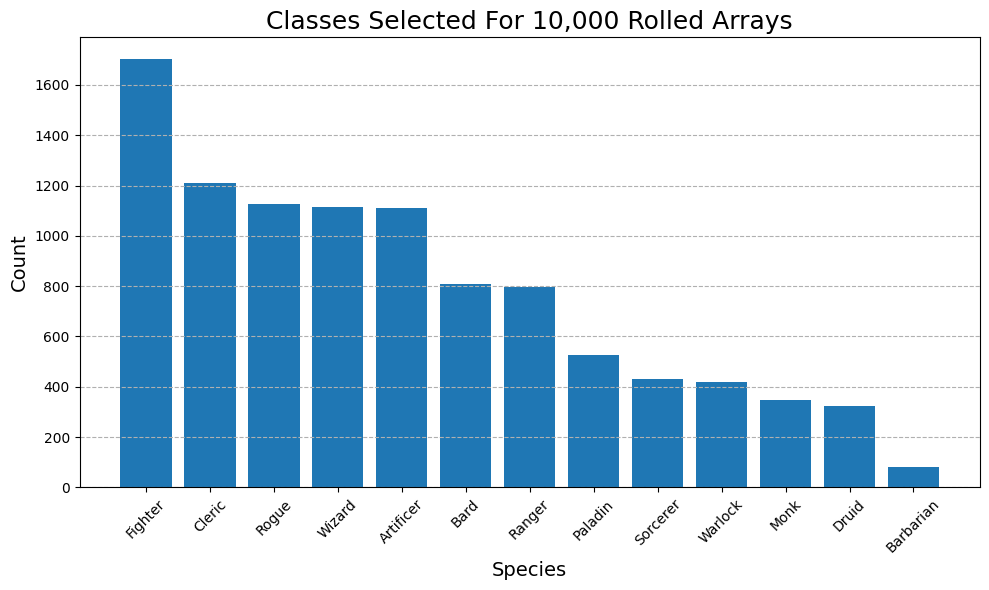

In [5]:
import matplotlib.pyplot as plt
sorted_species = sorted(class_results.items(), key=lambda item: item[1], reverse=True)
    
    # Unzip the sorted results into two lists
species, counts = zip(*sorted_species)

plt.figure(figsize=(10, 6))
plt.bar(species, counts)
plt.title('Classes Selected For 10,000 Rolled Arrays', fontsize = 18)
plt.xlabel('Species', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('results.png')

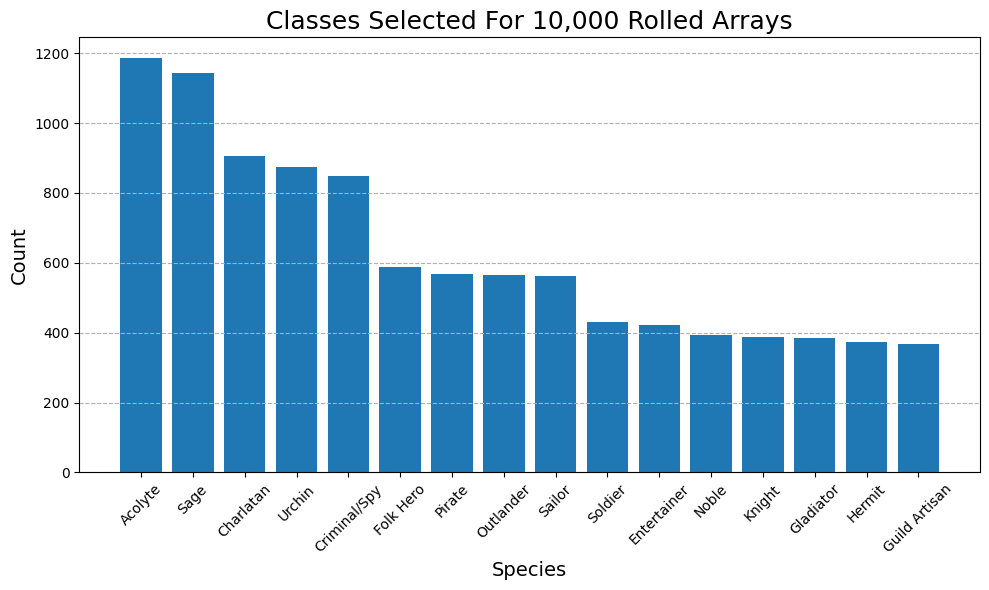

In [6]:
import matplotlib.pyplot as plt
sorted_species = sorted(background_results.items(), key=lambda item: item[1], reverse=True)
    
    # Unzip the sorted results into two lists
species, counts = zip(*sorted_species)

plt.figure(figsize=(10, 6))
plt.bar(species, counts)
plt.title('Classes Selected For 10,000 Rolled Arrays', fontsize = 18)
plt.xlabel('Species', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('results.png')